<a href="https://colab.research.google.com/github/ankesh86/PySparkNotebooks/blob/main/Unsupervised_Hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=3f6305c7460c1183d4079016ad7588f03112f085f51251f57f9be2b29540b85f
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
# Import Sparksession
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Clustering").getOrCreate()

In [4]:
# Print PySpark and Python versions
import sys
print('Python version: '+sys.version)
print('Spark version: '+spark.version)

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Spark version: 3.4.0


# Read data

In [3]:
file_location = "sample_data/cluster_data.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "true"

df = spark.read.format(file_type).option("inferSchema", infer_schema).option("header", first_row_is_header).load(file_location)

df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: string (nullable = true)
 |-- BALANCE_FREQUENCY: string (nullable = true)
 |-- PURCHASES: string (nullable = true)
 |-- ONEOFF_PURCHASES: string (nullable = true)
 |-- INSTALLMENTS_PURCHASES: string (nullable = true)
 |-- CASH_ADVANCE: string (nullable = true)
 |-- PURCHASES_FREQUENCY: string (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: string (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: string (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: string (nullable = true)
 |-- CASH_ADVANCE_TRX: string (nullable = true)
 |-- PURCHASES_TRX: string (nullable = true)
 |-- CREDIT_LIMIT: string (nullable = true)
 |-- PAYMENTS: string (nullable = true)
 |-- MINIMUM_PAYMENTS: string (nullable = true)
 |-- PRC_FULL_PAYMENT: string (nullable = true)
 |-- TENURE: string (nullable = true)



In [5]:
#  Count data
df.count()
print('The total number of records in the credit card dataset are '+str(df.count()))

The total number of records in the credit card dataset are 8950


## Casting variable to appropriate data types

In [6]:
# Casting multiple variables
from pyspark.sql.types import *

#Identifying and assiging lists of variables
float_vars=list(set(df.columns) - set(['CUST_ID']))

for column in float_vars:
	df=df.withColumn(column,df[column].cast(FloatType()))

## Imputing data

In [7]:
from pyspark.ml.feature import Imputer

input_cols = list(set(df.columns) - set(['CUST_ID']))

# Defining the imputer function
imputer = Imputer(
    inputCols=input_cols,
    outputCols=["{}_imputed".format(c) for c in input_cols])

# Applying the transformation
df_imputed=imputer.fit(df).transform(df)

# Dropping the original columns as we created the _imputed columns
df_imputed=df_imputed.drop(*input_cols)

# Renaming the input columns to original columns for consistency
new_column_name_list= list(map(lambda x: x.replace("_imputed", ""), df.columns))
df_imputed = df_imputed.toDF(*new_column_name_list)

In [9]:
df_imputed.head(10)

[Row(CUST_ID='C10001', BALANCE=40.90074920654297, BALANCE_FREQUENCY=0.8181819915771484, PURCHASES=0.0, ONEOFF_PURCHASES=0.0, INSTALLMENTS_PURCHASES=1000.0, CASH_ADVANCE=0.0, PURCHASES_FREQUENCY=95.4000015258789, ONEOFF_PURCHASES_FREQUENCY=201.8020782470703, PURCHASES_INSTALLMENTS_FREQUENCY=2.0, CASH_ADVANCE_FREQUENCY=0.16666699945926666, CASH_ADVANCE_TRX=0.0, PURCHASES_TRX=12.0, CREDIT_LIMIT=139.50978088378906, PAYMENTS=95.4000015258789, MINIMUM_PAYMENTS=0.0, PRC_FULL_PAYMENT=0.0, TENURE=0.08333300054073334),
 Row(CUST_ID='C10002', BALANCE=3202.467529296875, BALANCE_FREQUENCY=0.9090909957885742, PURCHASES=0.2222220003604889, ONEOFF_PURCHASES=0.0, INSTALLMENTS_PURCHASES=7000.0, CASH_ADVANCE=0.25, PURCHASES_FREQUENCY=0.0, ONEOFF_PURCHASES_FREQUENCY=4103.03271484375, PURCHASES_INSTALLMENTS_FREQUENCY=0.0, CASH_ADVANCE_FREQUENCY=0.0, CASH_ADVANCE_TRX=4.0, PURCHASES_TRX=12.0, CREDIT_LIMIT=1072.3402099609375, PAYMENTS=0.0, MINIMUM_PAYMENTS=6442.9453125, PRC_FULL_PAYMENT=0.0, TENURE=0.0),
 Row

## Data Preperation

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline

#Listing the variables that are not required in the segmentation analysis
ignore = ['CUST_ID']

#creating vector of all features
assembler = VectorAssembler(inputCols=[x for x in df.columns if x not in ignore], outputCol='features')
#creating the normalizer for all features
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)

# Defining the pipeline
pipeline = Pipeline(stages=[assembler, normalizer])
#fitting the pipeline
transformations = pipeline.fit(df_imputed)
# Applying the transformation
df_updated = transformations.transform(df_imputed)

## Building the model

In [12]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))

# Make predictions
predictions = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.49855848955649995
Cluster Centers: 
[1.67613049e-01 1.27041540e-04 1.37626105e-05 4.51778189e-02
 3.19911998e-01 2.07931012e-05 3.68880540e-02 1.56153161e-01
 1.35422759e-03 5.52450766e-05 4.36827025e-04 1.58891509e-03
 8.98395022e-02 8.20154181e-02 9.87433798e-02 2.00523886e-05
 4.07553710e-05]
[4.12514135e-02 1.49477386e-04 5.20146262e-05 2.60570968e-02
 6.69629544e-01 4.99429055e-06 4.13338382e-02 9.19431713e-02
 1.69572988e-03 1.07480745e-04 7.78368846e-05 2.36687998e-03
 4.21892243e-02 6.73444143e-02 1.56899718e-02 2.03692023e-05
 8.65430186e-05]


## Silhouette coefficient for different number of cluster and plot it to determine the right cluster number

Silhouette with squared euclidean distance for 2 cluster solution = 0.49855848955649995
Silhouette with squared euclidean distance for 3 cluster solution = 0.47048261757325865
Silhouette with squared euclidean distance for 4 cluster solution = 0.3683678751651746
Silhouette with squared euclidean distance for 5 cluster solution = 0.3591087613378825
Silhouette with squared euclidean distance for 6 cluster solution = 0.37906388228608356
Silhouette with squared euclidean distance for 7 cluster solution = 0.36425263724615137


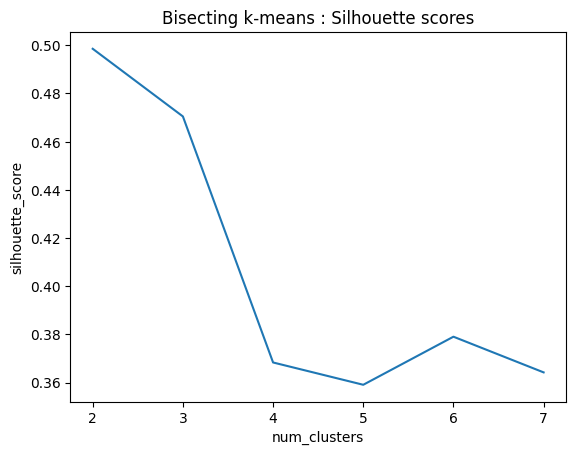

In [13]:
#Iterations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sil_coeff = []
num_clusters = []
for iter in range(2,8):
    bkm = BisectingKMeans().setK(iter).setSeed(1)
    model = bkm.fit(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    # Make predictions
    predictions = model.transform(df_updated.select('normFeatures').withColumnRenamed('normFeatures','features'))
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    sil_coeff.append(silhouette)
    num_clusters.append(iter)
    print("Silhouette with squared euclidean distance for "+str(iter) +" cluster solution = " + str(silhouette))

df_viz=pd.DataFrame(zip(num_clusters,sil_coeff), columns=['num_clusters','silhouette_score'])
sns.lineplot(x = "num_clusters", y = "silhouette_score", data=df_viz)
plt.title('Bisecting k-means : Silhouette scores')
plt.xticks(range(2, 8))
plt.show()